In [1]:
import itertools
import os
from pathlib import Path
import subprocess
import sys

from Bio import SeqIO
from Bio.Align import MultipleSeqAlignment
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
from scipy.spatial.distance import hamming
import seaborn as sns
from tqdm.notebook import tqdm

sys.path.append('../../bitome2')
sys.path.append('../')

from bitome.core import Bitome
from feature_functions import *
from math import log,inf

In [2]:
K12_DATA_PATH = Path('../data/bitome2/mg1655')

# need to edit the path
FINDER_PATH = Path('../../BTSSFINDER/BTSSFINDER/bTSSfinder')
BLAST_PATH = Path('../data/multi_strain_blast/')
OP_PATH = Path('../data/multistrain_blast_operon/')
Prom_PATH = Path('../data/promoter_pred/')

In [3]:
origin = (3925743, 3925975)
terminus = (1341745, 1609180)
cid_boundaries = [50000, 142779, 223485, 446815, 927474, 985894, 1080000, 1195008, 1301085, 1577657,
                 1799393, 1852621, 2102875, 2259719, 2380722, 2533498, 2726069, 2905711, 2996372, 3297098,
                 3423423, 3440040, 3652182, 3811250, 3941516, 4035239, 4166484, 4470986]

mg1655 = Bitome(
    Path(K12_DATA_PATH, 'NC_000913.3.gb'),
    name='MG1655',
    origin=origin, terminus=terminus,
    cid_boundaries=cid_boundaries,
    gene_table=Path(K12_DATA_PATH, 'gene_info_supp.csv'),
    tu_table=Path(K12_DATA_PATH, 'tu.csv'),
    operon_table=Path(K12_DATA_PATH, 'operon_bitomekb.csv'),
    tss_table=Path(K12_DATA_PATH, 'tss.csv'),
    # TODO PARSE TTS data
    tts_table=None,
    tfbs_table=Path(K12_DATA_PATH, 'tfbs.csv'),
    terminator_table=Path(K12_DATA_PATH, 'terminator.csv'),
    attenuator_table=Path(K12_DATA_PATH, 'attenuator.csv'),
    rbs_table=Path(K12_DATA_PATH, 'rbs.csv'),
    riboswitch_table=Path(K12_DATA_PATH, 'riboswitch.csv')
)

## multistrain bitomes

In [4]:
bitomes_by_id = {}

genome_dir = Path('..', 'data', 'e_coli_genomes', 'refseq')

for file in os.listdir(genome_dir):
    gb_id = file.split('.')[0]
    bitome = Bitome(Path(genome_dir, file),cid_boundaries=cid_boundaries)
    b_id = bitome.reference_id
    # print(b_id)
    tu_table_path = Path('../data/Fur_multistrain_SN/'+b_id[0:-2] +'_' + b_id[-1], 'tu.csv')
    op_table_path = Path('../data/Fur_multistrain_SN/'+b_id[0:-2] +'_' + b_id[-1], 'operon.csv')
    bitome = Bitome(Path(genome_dir, file),cid_boundaries=cid_boundaries,
                    tu_table= tu_table_path, operon_table = op_table_path)
    bitomes_by_id[bitome.reference_id] = bitome

In [5]:
bitomes_by_id

{'NC_012971.2': <bitome.core.Bitome at 0x7f28c8721580>,
 'NC_010468.1': <bitome.core.Bitome at 0x7f2800505340>,
 'NC_004431.1': <bitome.core.Bitome at 0x7f28000ff880>,
 'NC_007779.1': <bitome.core.Bitome at 0x7f2800ee62e0>,
 'NC_017660.1': <bitome.core.Bitome at 0x7f28013f5250>,
 'NC_017626.1': <bitome.core.Bitome at 0x7f27f9a8adc0>,
 'NC_002695.1': <bitome.core.Bitome at 0x7f27f37cf310>,
 'NC_017635.1': <bitome.core.Bitome at 0x7f2800789790>}

In [6]:
print([(b.description, b.reference_id) for b in bitomes_by_id.values()])
id_to_name = {
    'NC_004431.1': 'CFT073','NC_017626.1': '042','NC_007779.1': 'W3110',
    'NC_002695.1': 'O157:H7','NC_010468.1': 'Crooks','NC_017660.1': 'KO11FL',
    'NC_012971.2': 'BL21','NC_017635.1': 'W'
}
name_to_id = {}
for ID in id_to_name.keys():
    name_to_id[ id_to_name[ID]] = ID

[('Escherichia coli BL21(DE3), complete genome', 'NC_012971.2'), ('Escherichia coli ATCC 8739, complete genome', 'NC_010468.1'), ('Escherichia coli CFT073, complete genome', 'NC_004431.1'), ('Escherichia coli str. K-12 substr. W3110 DNA, complete genome', 'NC_007779.1'), ('Escherichia coli KO11FL, complete genome', 'NC_017660.1'), ('Escherichia coli 042 complete genome', 'NC_017626.1'), ('Escherichia coli O157:H7 str. Sakai, complete genome', 'NC_002695.1'), ('Escherichia coli W, complete genome', 'NC_017635.1')]


## assess sequence quality

In [7]:
def count_und( seq ):
    count = seq.count('A') + seq.count('T') + seq.count('C') + seq.count('G')
    return len(seq) - count

In [8]:
name_to_id

{'CFT073': 'NC_004431.1',
 '042': 'NC_017626.1',
 'W3110': 'NC_007779.1',
 'O157:H7': 'NC_002695.1',
 'Crooks': 'NC_010468.1',
 'KO11FL': 'NC_017660.1',
 'BL21': 'NC_012971.2',
 'W': 'NC_017635.1'}

<BarContainer object of 8 artists>

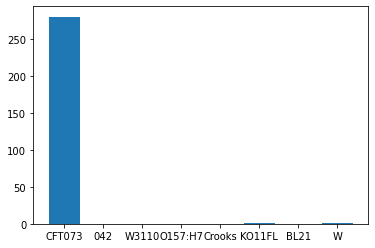

In [9]:
und_count = []
for k in name_to_id.keys():
    num = count_und( bitomes_by_id[name_to_id[k]].sequence )
    und_count.append( num )

plt.bar( list(name_to_id.keys()) , und_count )

In [10]:
with open(Path(Prom_PATH, 'mg1655_genes.fasta'), 'w') as file_out:
    
    clean_gene_table = mg1655.gene_table[(mg1655.gene_table['left'].notna()) & (mg1655.gene_table['right'].notna()) & 
                                    (mg1655.gene_table['strand'].notna()) ]
    
    for row in clean_gene_table.itertuples():
        if row.left < 400:
            continue
        if row.strand == 1:
            seq = str(mg1655.get_sequence(row.left-400, row.right, row.strand))
        else:
            seq = str(mg1655.get_sequence(row.left, row.right+400, row.strand))
            
        file_out.write(f'>{row.Index}\n{seq}\n')

In [11]:
import os
os.environ["bTSSfinder_Data"] = "../../BTSSFINDER/BTSSFINDER/Data" 
#export bTSSfinder_Data="../../BTSSFINDER/BTSSFINDER/Data"

In [12]:
# RUN BTSSFINDER 
# 1.90, 1.91, 1.92, 1.95

subprocess.check_output([FINDER_PATH,
                             '-i', Path(Prom_PATH, 'mg1655_genes.fasta'),
                             '-o', Path(Prom_PATH, 'mg1655'), '-h', '2','-t', 'e', '-c', '70', '-a', '1.90' ])

b''

In [13]:
pred_columns = ['gene_id','pred_start','pred_end','feature_name',
                'score','strand','thickStart','thickEnd','RGB','num_blocks','block_size','block_start']

In [14]:
mg1655_pred = pd.read_table( Path(Prom_PATH, 'mg1655.bed'), header= None )
mg1655_pred.columns = pred_columns
mg1655_pred = mg1655_pred[ (mg1655_pred['thickStart']<400) ]
mg1655_pred = mg1655_pred.reset_index()
mg1655_pred = mg1655_pred.drop(columns=['index'])

In [15]:
mg1655_pred

,gene_id,pred_start,pred_end,feature_name,score,strand,thickStart,thickEnd,RGB,num_blocks,block_size,block_start
0,b0005,1,500,sigma70_TSS1+,0,+,257,257,"255,0,0",2,"6,6","218,243"
1,b0005,1,500,sigma70_TSS1-,0,-,243,243,"255,0,0",2,"6,6","276,255"
2,b0006,1,500,sigma70_TSS1-,0,-,133,133,"255,0,0",2,"6,6","168,145"
3,b0007,1,500,sigma70_TSS1+,0,+,344,344,"255,0,0",2,"6,6","311,332"
4,b0007,1,500,sigma70_TSS1-,0,-,299,299,"255,0,0",2,"6,6","335,312"
...,...,...,...,...,...,...,...,...,...,...,...,...
4845,b4401,1,500,sigma70_TSS1+,0,+,237,237,"255,0,0",2,"6,6","203,225"
4846,b4401,1,500,sigma70_TSS1-,0,-,297,297,"255,0,0",2,"6,6","331,309"
4847,b4402,1,500,sigma70_TSS1-,0,-,231,231,"255,0,0",2,"6,6","269,243"
4848,b4403,1,500,sigma70_TSS1+,0,+,209,209,"255,0,0",2,"6,6","172,197"


(array([ 60.,  43.,  33.,  40.,  55.,  38.,  44.,  41.,  46.,  28.,  41.,
         39.,  37.,  56.,  60.,  54.,  52.,  52.,  72.,  57.,  68., 110.,
        133., 104.,  99., 126., 152., 137., 152., 160., 165., 162., 174.,
        183., 217., 231.,  70.,  82.,  79., 100.,  82.,  92.,  88.,  94.,
        125., 145., 246., 115., 122.,  89.]),
 array([-349.  , -342.04, -335.08, -328.12, -321.16, -314.2 , -307.24,
        -300.28, -293.32, -286.36, -279.4 , -272.44, -265.48, -258.52,
        -251.56, -244.6 , -237.64, -230.68, -223.72, -216.76, -209.8 ,
        -202.84, -195.88, -188.92, -181.96, -175.  , -168.04, -161.08,
        -154.12, -147.16, -140.2 , -133.24, -126.28, -119.32, -112.36,
        -105.4 ,  -98.44,  -91.48,  -84.52,  -77.56,  -70.6 ,  -63.64,
         -56.68,  -49.72,  -42.76,  -35.8 ,  -28.84,  -21.88,  -14.92,
          -7.96,   -1.  ]),
 <BarContainer object of 50 artists>)

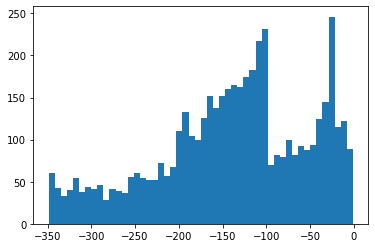

In [16]:
plt.hist( np.array( [(x-400) for x in mg1655_pred['thickStart']] ), bins = 50)

In [17]:
tss_list = []
for i in range( len(mg1655_pred['gene_id']) ):
    g_id = list(mg1655_pred['gene_id'])[i]
    thickstart = list(mg1655_pred['thickStart'])[i]
    strand = mg1655.gene_table.loc[g_id].strand
    left = mg1655.gene_table.loc[g_id].left
    right = mg1655.gene_table.loc[g_id].right
    if type(strand) != np.int64:
        strand = strand[0]
        left = left[0]
        right = right[0]
    if strand == 1:
        tss_list.append( left -400 + thickstart )
    else:
        tss_list.append( right+400 - thickstart )
mg1655_pred['tss_pred'] = tss_list

In [129]:
mg1655_pred[5:]

,gene_id,pred_start,pred_end,feature_name,score,strand,thickStart,thickEnd,RGB,num_blocks,block_size,block_start,tss_pred
5,b0007,1,500,sigma70_TSS1-,0,-,299,299,"255,0,0",2,"6,6","335,312",8060
6,b0008,1,500,sigma70_TSS1+,0,+,224,224,"255,0,0",2,"6,6","188,211",8062
7,b0008,1,500,sigma70_TSS1-,0,-,179,179,"255,0,0",2,"6,6","212,191",8017
8,b0009,1,500,sigma70_TSS1-,0,-,227,227,"255,0,0",2,"6,6","263,239",9133
9,b0010,1,500,sigma70_TSS1+,0,+,333,333,"255,0,0",2,"6,6","297,320",10561
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7583,b4401,1,500,sigma70_TSS1+,0,+,237,237,"255,0,0",2,"6,6","203,225",4640469
7584,b4401,1,500,sigma70_TSS1-,0,-,297,297,"255,0,0",2,"6,6","331,309",4640409
7585,b4402,1,500,sigma70_TSS1-,0,-,231,231,"255,0,0",2,"6,6","269,243",4640233
7586,b4403,1,500,sigma70_TSS1+,0,+,209,209,"255,0,0",2,"6,6","172,197",4640751


In [20]:
tss = 36166
mg1655.features_in_range( tss-20, tss+20)

,left,right,strand,pseudo,name,cog,essential,y-ome,tpm,tpm_ctrl,tpm_all,reg_effect,log_tpm,type,tss,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right
locus_tag,,,,,,,,,,,,,,,,,,,,
b0036,35377.0,36162.0,-1.0,False,caiD,I,NaN,well-annotated,1.415302,1.183032,1.416581,dual,1.272204,gene,NaN,NaN,NaN,NaN,NaN,NaN
b0036,35377.0,36162.0,-1.0,NaN,carnitinyl-CoA dehydratase,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,protein,NaN,NaN,NaN,NaN,NaN,NaN
ECK120009437,34781.0,42037.0,-1.0,NaN,caiTABCDE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tu,42037.0,Sigma70,42044.0,42049.0,42071.0,42076.0
ECK120033587,34781.0,37824.0,-1.0,NaN,caiCDE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tu,NaN,NaN,NaN,NaN,NaN,NaN
ECK120014786,34781.0,42272.0,-1.0,NaN,caiTABCDE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,operon,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
tu_df = mg1655.tu_table
tu_df

,name,strand,tss,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right,left,right
locus_tag,,,,,,,,,,
ECK120008913,astCADBE,-1.0,1832013.0,Sigma70,1832022.0,1832027.0,1832047.0,1832052.0,1825955.0,1832013.0
ECK120008914,astCADBE,-1.0,1832044.0,Sigma54,1832054.0,1832058.0,1832065.0,1832070.0,1825955.0,1832044.0
ECK120008915,astCADBE,-1.0,1832039.0,Sigma38,1832046.0,1832056.0,1832070.0,1832075.0,1825955.0,1832039.0
ECK120008916,nrdHIEF,1.0,2800656.0,Sigma70,2800644.0,2800649.0,2800621.0,2800626.0,2800656.0,2804461.0
ECK120008917,cpxPQ,1.0,4105785.0,Sigma70,4105772.0,4105777.0,4105746.0,4105751.0,4105785.0,4106379.0
...,...,...,...,...,...,...,...,...,...,...
ECK125285343,argH,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4156850.0,4158223.0
ECK125285344,aroD,1.0,1774571.0,Sigma70,1774561.0,1774566.0,1774535.0,1774540.0,1774571.0,1775444.0
ECK125285345,yihUTS,-1.0,4073606.0,Sigma70,NaN,NaN,NaN,NaN,4070515.0,4073606.0


In [19]:
# ignore the NAN tss since there's only three of them
tu_clean = tu_df[tu_df['sigma_factor'] =='Sigma70']
tu_clean = tu_clean.dropna(subset=['tss'])

In [20]:
# ## known tss +/- 50bp and test whether it works

# true_pos = 0
# true_neg = 10000


# for pred_tss in mg1655_pred['tss_pred']:

#         find_tss = mg1655.features_in_range( pred_tss-10, pred_tss+10)
#         if (len(find_tss) != 0) and ('sigma_factor' in find_tss.columns):
#             true_tss = find_tss[(find_tss['sigma_factor']=='Sigma70') ]
#             if true_tss.shape[0] == 1:
#                 true_pos += 1
            
#                 truepos_gene.append(find_tss['tss'])
                
true_pos = 0
truepos_gene = []
for pred_tss in mg1655_pred['tss_pred']:
    for true_tss in tu_clean['tss']:
        if pred_tss in range(int(true_tss)-10, int(true_tss)+10):
            true_pos += 1
            truepos_gene.append(pred_tss)
        

In [28]:
tu_truepos

,name,strand,tss,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right,left,right,locus_tag
0,rrsH-ileV-alaV-rrlH-rrfH,1.0,223593.0,Sigma70,223581.0,223586.0,NaN,NaN,223593.0,228875.0,ECK120008935
1,pth-ychF,-1.0,1258542.0,Sigma70,1258550.0,1258555.0,1258573.0,1258578.0,1256721.0,1258542.0,ECK120008956
2,metNIQ,-1.0,222714.0,Sigma70,222722.0,222727.0,222745.0,222750.0,220113.0,222714.0,ECK120008970
3,metJ,-1.0,4128529.0,Sigma70,4128537.0,4128542.0,4128560.0,4128565.0,4128078.0,4128529.0,ECK120008984
4,metBL,1.0,4128636.0,Sigma70,4128623.0,4128628.0,4128600.0,4128605.0,4128636.0,4132456.0,ECK120009005
...,...,...,...,...,...,...,...,...,...,...,...
61,dapB,1.0,28288.0,Sigma70,28275.0,28280.0,28253.0,28258.0,28288.0,29272.0,ECK120030636
62,NaN,-1.0,1582554.0,Sigma70,1582562.0,1582567.0,1582585.0,1582590.0,1579633.0,1582554.0,ECK125135682
63,rybA-mntS,-1.0,853064.0,Sigma70,853072.0,853077.0,853093.0,853098.0,852725.0,853064.0,ECK125140764
64,dksA-gluQ,-1.0,160751.0,Sigma70,160759.0,160764.0,160782.0,160787.0,159186.0,160751.0,ECK125145765


# Profiling

In [22]:
# extract the truepos and falsepos
tss_truepos = mg1655_pred[mg1655_pred['tss_pred'].isin(truepos_gene)]
tss_falsepos = mg1655_pred[~mg1655_pred['tss_pred'].isin(truepos_gene)]

In [23]:
tu_truepos = tu_clean[tu_clean['tss'].isin(truepos_gene)]
tu_falseneg = tu_clean[~tu_clean['tss'].isin(truepos_gene)]

In [24]:
locus_tag = tu_truepos.index
tu_truepos.set_index(pd.Index(list(range(len(locus_tag)))),inplace=True)
tu_truepos['locus_tag'] = locus_tag

locus_tag = tu_falseneg.index
tu_falseneg.set_index(pd.Index(list(range(len(locus_tag)))),inplace=True)
tu_falseneg['locus_tag'] = locus_tag


tu_truepos.to_csv(Path(Prom_PATH, 'tu_truepos.csv'))
tu_falseneg.to_csv(Path(Prom_PATH, 'tu_falseneg.csv'))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [27]:
tss_falsepos.to_csv(Path(Prom_PATH, 'tss_falsepos.csv'))

In [150]:
mg1655_truepos = Bitome(
    Path(K12_DATA_PATH, 'NC_000913.3.gb'),
    name='MG1655',
    origin=origin, terminus=terminus,
    cid_boundaries=cid_boundaries,
    gene_table=Path(K12_DATA_PATH, 'gene_info_supp.csv'),
    tu_table=Path(Prom_PATH, 'tu_truepos.csv'),
    operon_table=Path(K12_DATA_PATH, 'operon_bitomekb.csv'),
    #tss_table=Path(K12_DATA_PATH, 'tss.csv'),
    # TODO PARSE TTS data
    tts_table=None,
    tfbs_table=Path(K12_DATA_PATH, 'tfbs.csv'),
    terminator_table=Path(K12_DATA_PATH, 'terminator.csv'),
    attenuator_table=Path(K12_DATA_PATH, 'attenuator.csv'),
    rbs_table=Path(K12_DATA_PATH, 'rbs.csv'),
    riboswitch_table=Path(K12_DATA_PATH, 'riboswitch.csv')
)

In [151]:
mg1655_falseneg = Bitome(
    Path(K12_DATA_PATH, 'NC_000913.3.gb'),
    name='MG1655',
    origin=origin, terminus=terminus,
    cid_boundaries=cid_boundaries,
    gene_table=Path(K12_DATA_PATH, 'gene_info_supp.csv'),
    tu_table=Path(Prom_PATH, 'tu_falseneg.csv'),
    operon_table=Path(K12_DATA_PATH, 'operon_bitomekb.csv'),
    #tss_table=Path(K12_DATA_PATH, 'tss.csv'),
    # TODO PARSE TTS data
    tts_table=None,
    tfbs_table=Path(K12_DATA_PATH, 'tfbs.csv'),
    terminator_table=Path(K12_DATA_PATH, 'terminator.csv'),
    attenuator_table=Path(K12_DATA_PATH, 'attenuator.csv'),
    rbs_table=Path(K12_DATA_PATH, 'rbs.csv'),
    riboswitch_table=Path(K12_DATA_PATH, 'riboswitch.csv')
)

## Profiling 5' UTRs

In [152]:
# true_pos
utr_lens = []
for tu_row in mg1655_truepos.tu_table.itertuples():
    if pd.notna(tu_row.tss):
        tu_gene_df = mg1655_truepos.gene_table.loc[mg1655_truepos._tu_to_genes[tu_row.Index]]
        if not tu_gene_df.empty:
            if tu_row.strand == 1:
                first_gene_start = tu_gene_df.sort_values(by='left').iloc[0, :]['left']
            else:
                first_gene_start = tu_gene_df.sort_values(by='right', ascending=False).iloc[0, :]['right']
            utr_len = abs(tu_row.tss - first_gene_start)
            utr_lens.append(utr_len)

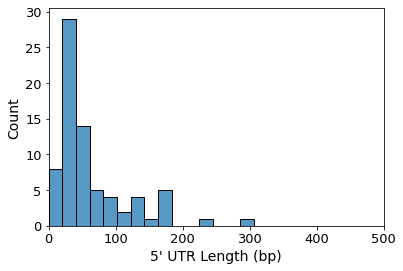

In [153]:
_, ax = plt.subplots()
sns.histplot(utr_lens)
ax.set_xlim(0, 500)
ax.set_xlabel("5' UTR Length (bp)", fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.tick_params(axis='both', labelsize=13)

In [154]:
# false_neg
utr_lens = []
for tu_row in mg1655_falseneg.tu_table.itertuples():
    if pd.notna(tu_row.tss):
        tu_gene_df = mg1655_falseneg.gene_table.loc[mg1655_falseneg._tu_to_genes[tu_row.Index]]
        if not tu_gene_df.empty:
            if tu_row.strand == 1:
                first_gene_start = tu_gene_df.sort_values(by='left').iloc[0, :]['left']
            else:
                first_gene_start = tu_gene_df.sort_values(by='right', ascending=False).iloc[0, :]['right']
            utr_len = abs(tu_row.tss - first_gene_start)
            utr_lens.append(utr_len)

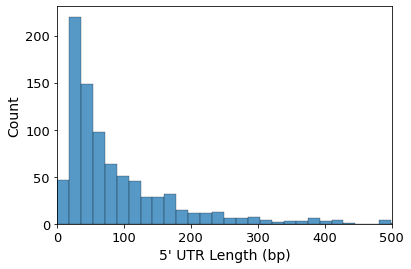

In [155]:
_, ax = plt.subplots()
sns.histplot(utr_lens)
ax.set_xlim(0, 500)
ax.set_xlabel("5' UTR Length (bp)", fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.tick_params(axis='both', labelsize=13)

## TSS within gene

In [156]:
tss_in_gene_count = 0
for tu_row in mg1655_truepos.tu_table.itertuples():
    if pd.notna(tu_row.tss):
        gene_in_tss = mg1655_truepos.gene_table[
            (mg1655_truepos.gene_table['left'] < tu_row.tss) & 
            (mg1655_truepos.gene_table['right'] > tu_row.tss) & 
            (mg1655_truepos.gene_table['strand'] == tu_row.strand)
        ]
        tss_in_gene_count += gene_in_tss.shape[0]

print(f'{tss_in_gene_count} cases of TSS located within gene on same strand')

6 cases of TSS located within gene on same strand


In [157]:
tss_in_gene_count = 0
for tu_row in mg1655_falseneg.tu_table.itertuples():
    if pd.notna(tu_row.tss):
        gene_in_tss = mg1655_falseneg.gene_table[
            (mg1655_falseneg.gene_table['left'] < tu_row.tss) & 
            (mg1655_falseneg.gene_table['right'] > tu_row.tss) & 
            (mg1655_falseneg.gene_table['strand'] == tu_row.strand)
        ]
        tss_in_gene_count += gene_in_tss.shape[0]

print(f'{tss_in_gene_count} cases of TSS located within gene on same strand')

89 cases of TSS located within gene on same strand


## Promoter shape

In [167]:
shape_z_score_df = mg1655.tss_search_shape_stats()
shape_z_score_df

CalledProcessError: Command '['Rscript', '../../bitome2/bitome/shape_work_dir/compute_shape.R']' died with <Signals.SIGSEGV: 11>.

# Different threshold and plotting

<AxesSubplot:>

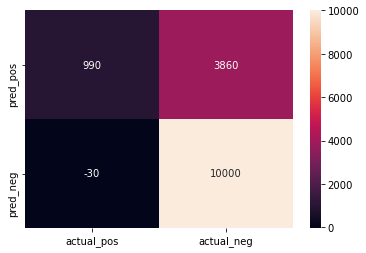

In [309]:
false_neg = tu_clean.shape[0]- true_pos
false_pos = mg1655_pred.shape[0] - true_pos
confusion_M = np.array([[true_pos, false_pos], [false_neg, true_neg]])
sns.heatmap(confusion_M, xticklabels = ['actual_pos', 'actual_neg'], yticklabels = ['pred_pos', 'pred_neg'], 
            fmt = '.5g', annot=True)

# 1.90 almost get all the positive

In [347]:
confusion_M.reshape(1,2,2)

array([[[   34,   926],
        [  794, 10000]]])

In [327]:
precision = true_pos/(true_pos + false_pos)
recall = true_pos/(true_pos + false_neg)

In [328]:
f1 = 2*precision*recall/(precision+recall)

In [343]:
M = np.dstack((np.zeros((2,2)),np.zeros((2,2))))

In [348]:
np.concatenate((M, confusion_M.reshape(1,2,2)))

array([[[    0.,     0.],
        [    0.,     0.]],

       [[    0.,     0.],
        [    0.,     0.]],

       [[   34.,   926.],
        [  794., 10000.]]])

In [421]:
true_neg = 2200000
results_dict = {
    'confsM': np.zeros((2,2)),
    'precision': [],
    'recall': [],
    'f1': [],
    
}
   
for thres in ['0.5', '1', '1.25', '1.5', '1.90', '1.91', '1.92','1.93', '1.95', '1.98']:
    subprocess.check_output([FINDER_PATH,
                             '-i', Path(Prom_PATH, 'mg1655_genes.fasta'),
                             '-o', Path(Prom_PATH, 'mg1655'), '-h', '2','-t', 'e', '-c', '70', '-a', thres ])
    
    mg1655_pred = pd.read_table( Path(Prom_PATH, 'mg1655.bed'), header= None )
    mg1655_pred.columns = pred_columns
    mg1655_pred = mg1655_pred[ (mg1655_pred['thickStart']<400) ]
    mg1655_pred = mg1655_pred.reset_index()
    mg1655_pred = mg1655_pred.drop(columns=['index'])
    
    tss_list = []
    
    for i in range( len(mg1655_pred['gene_id']) ):
        g_id = list(mg1655_pred['gene_id'])[i]
        thickstart = list(mg1655_pred['thickStart'])[i]
        strand = mg1655.gene_table.loc[g_id].strand
        left = mg1655.gene_table.loc[g_id].left
        right = mg1655.gene_table.loc[g_id].right
        if type(strand) != np.int64:
            strand = strand[0]
            left = left[0]
            right = right[0]
        if strand == 1:
            tss_list.append( left -400 + thickstart )
        else:
            tss_list.append( right+400 - thickstart )
    mg1655_pred['tss_pred'] = tss_list
    
    
    true_pos = 0
    truepos_gene = []
    for pred_tss in mg1655_pred['tss_pred']:
        for true_tss in tu_clean['tss']:
            if pred_tss in range(int(true_tss)-10, int(true_tss)+10):
                true_pos += 1
                truepos_gene.append(pred_tss)
                    
        
    false_neg = tu_clean.shape[0]- true_pos
    false_pos = mg1655_pred.shape[0] - true_pos
    confusion_M = np.array([[true_pos, false_neg], [false_pos, true_neg]])
    
    # print(true_pos)
        
        
    precision = true_pos/(true_pos + false_pos)
    recall = true_pos/(true_pos + false_neg)
    f1 = 2*precision*recall/(precision+recall)
        
    results_dict['confsM'] = np.dstack((results_dict['confsM'], confusion_M))
    results_dict['precision'].append(precision)
    results_dict['recall'].append(recall)
    results_dict['f1'].append(f1)

        
results_dict['confsM'] = results_dict['confsM'].T
results_dict['confsM'] = results_dict['confsM'][1:]

KeyboardInterrupt: 

In [381]:
fpr = np.divide(results_dict['confsM'][:,0,1], (np.ones(8)*true_neg + results_dict['confsM'][:,1,0]))
tpr = results_dict['recall']

Text(0.5, 1.0, 'AUC curve for eight thresholds')

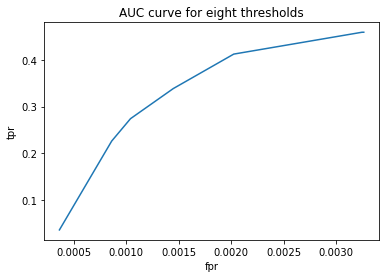

In [382]:
plt.plot(fpr, tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('AUC curve for eight thresholds')

Text(0.5, 1.0, 'PR curve for eight thresholds')

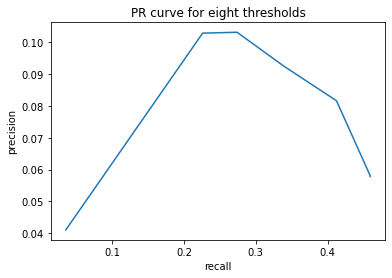

In [383]:
plt.plot(results_dict['recall'], results_dict['precision'])
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('PR curve for eight thresholds')

In [379]:
results_dict['precision']

[0.05783606557377049,
 0.058118081180811805,
 0.08164948453608248,
 0.0926189797663152,
 0.10317771675166731,
 0.10289236605026078,
 0.04106280193236715,
 0.04106280193236715]

In [380]:
results_dict['recall']

[0.459375,
 0.459375,
 0.4125,
 0.3385416666666667,
 0.27395833333333336,
 0.22604166666666667,
 0.035416666666666666,
 0.035416666666666666]

In [384]:
results_dict['f1']

[0.10273733255678508,
 0.1031820308844174,
 0.13631669535283994,
 0.1454464085925263,
 0.14990025648332858,
 0.1414141414141414,
 0.03803131991051454,
 0.03803131991051454]